To note:

- No idea what b is 
- Below is a couple of definitions from the GitHub page which might come in handy

Link travel time = free flow time * ( 1 + B * (flow/capacity)^Power ).
Link generalized cost = Link travel time + toll_factor * toll + distance_factor * distance

# Setup: import packages

In [1]:
#install packages if required
#%pip install networkx

In [2]:
#import packages 
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
from scipy.misc import derivative
import os
from random import *

In [3]:
network_analysis_path_ben = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/pytrans_UrbanNetworkAnalysis/pytrans/UrbanNetworkAnalysis/testing'
#network_analysis_path_niamh = r'C:\Users\35387\OneDrive\Documents\Networks\New folder\Networks_Term_Paper\pytrans_UrbanNetworkAnalysis\pytrans\UrbanNetworkAnalysis\original_edited'
os.chdir(network_analysis_path_ben)
import Frank_Wolfe
import TransportationNetworks as tn
import visualize_graph

In [4]:
#create cities dictionary
def make_dict(cities):
    cities_dict = {}
    for city in cities:
        link_file_path = data_path + city + '/' + city + '_net.tntp.txt'
        node_file_path = data_path + city + '/' + city +'_nodes.tntp.txt'
        trip_file_path = data_path + city + '/' + city + '_trips.tntp.txt'
        cities_dict[city] = {}
        to_add = {'link_file_path': link_file_path, 'node_file_path': node_file_path, 'trip_file_path': trip_file_path}
        cities_dict[city]['file_paths'] = to_add 
    return cities_dict

In [5]:
#create class
class fw_custom_algorithm():
    
    def __init__(self, cities_dict):
        self.cities_dict = cities_dict
        self.link_fields = {"from": 1, "to": 2, "capacity": 3, "length": 4, "t0": 5, "B": 6, "beta": 7, "V": 8}
    #create a csv for each city and corresponding file for investigation
 
    #need to fix this to make 
    def create_links_csv(self):
        for city in self.cities_dict.keys():
            path_list = list(self.cities_dict[city]['file_paths'])
            link_file = path_list[0]
            csv = pd.read_csv(self.cities_dict[city]['file_paths'][link_file], skiprows=7, sep='\t') #gets link file path
            trimmed= [s.strip().lower() for s in csv.columns]
            csv.columns = trimmed
            # And drop the silly first andlast columns
            csv.drop(['~', ';'], axis=1, inplace=True)
            cities_dict[city]['csv'] = csv
        self.cities_dict = cities_dict
    
    def plot(self, city):
        csv = self.cities_dict[city]['csv']
        network = nx.from_pandas_edgelist(csv, source = 'init node',target='term node', edge_attr = True)
        graph = nx.complete_graph(network)
        print('Graph for:', city)
        nx.draw(graph)
        
    def summary_stats_all(self):
        for city in self.cities_dict.keys():
            print('Total number of nodes in', city+':', len(self.cities_dict[city]['csv']['init node'].unique()))
            print('Total number of edges in', city+':', self.cities_dict[city]['csv'].shape[0])
            
    def network(self, city):
        #instatiate class using required files 
        link_file = self.cities_dict[city]['file_paths']['link_file_path']
        trip_file = self.cities_dict[city]['file_paths']['trip_file_path']
        node_file = self.cities_dict[city]['file_paths']['node_file_path']
        Network = tn.Network(link_file, trip_file, node_file)
        ##Network has three attributes
        #1) graph object
        graph = Network.graph
        #2) origin nodes
        origin_nodes = Network.origins
        #3)dict: keys= origin_node, destination_node, value = traffic flow
        flows = Network.od_vols
        print(Network)
        print(city, 'graph is:', graph)
        print(city, 'origin nodes are:', origin_nodes)
        print(city, 'flows are:', flows)
        
    #define a function for finding the equilibrim flow using the Frank-Wolfe algorithm from PyTrans
    def compute_all_link_flow(self, city):
        link_file = self.cities_dict[city]['file_paths']['link_file_path']
        trip_file = self.cities_dict[city]['file_paths']['trip_file_path']
        node_file = self.cities_dict[city]['file_paths']['node_file_path']    
        SO = False
        fw = Frank_Wolfe.Run(link_file, trip_file, node_file, SO)
        #saves file to dict
        self.cities_dict[city]['all_links'] = {'all_links': fw}
    
    def compute_missing_link_flow(self, city):   
        link_file = self.cities_dict[city]['file_paths']['link_file_path']
        trip_file = self.cities_dict[city]['file_paths']['trip_file_path']
        node_file = self.cities_dict[city]['file_paths']['node_file_path'] 
        link = 0
        total_links = cities_dict[city]['csv'].shape[0]
        for link in list(range(0, total_links+1)):
            link_file_missing_link = self.remove_link(city, link_file, link)
            while link <= total_links:
                SO = False
                fw = Frank_Wolfe.Run(link_file_missing_link, trip_file, node_file, SO)
                self.cities_dict[city]['closed_links'] = {str(link) : fw}
                link += 1
    
    #def remove_link(self, city, link_file, link):
    #    f = open(link_file)
     #   lines = f.readlines()
      #  f.close()
        
        
    


# Set file paths

In [6]:
data_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/'
cities = ['testing']
data_path = data_path 
os.chdir(data_path)

# Make dict

In [7]:
cities_dict = make_dict(cities)
cities_dict

{'testing': {'file_paths': {'link_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/testing/testing_net.tntp.txt',
   'node_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/testing/testing_nodes.tntp.txt',
   'trip_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/testing/testing_trips.tntp.txt'}}}

# instantiate class

In [8]:
#instantiate class 
trial_run = fw_custom_algorithm(cities_dict)

# Observe one city

In [9]:
#set city for investigation
city = cities[0]

In [10]:
trial_run.create_links_csv()
cities_dict[city]['csv']

,init node,term node,capacity,length,free flow time,b,power,speed limit,toll,type
0,1,2,25900.200640,6,6,0.15,4,0,0,1
1,1,3,23403.473190,4,4,0.15,4,0,0,1
2,2,1,25900.200640,6,6,0.15,4,0,0,1
3,2,6,4958.180928,5,5,0.15,4,0,0,1
4,3,1,23403.473190,4,4,0.15,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...
71,23,22,5000.000000,4,4,0.15,4,0,0,1
72,23,24,5078.508436,2,2,0.15,4,0,0,1
73,24,13,5091.256152,4,4,0.15,4,0,0,1
74,24,21,4885.357564,3,3,0.15,4,0,0,1


# Plot graph

Total number of nodes in testing: 24
Total number of edges in testing: 76
Graph for: testing


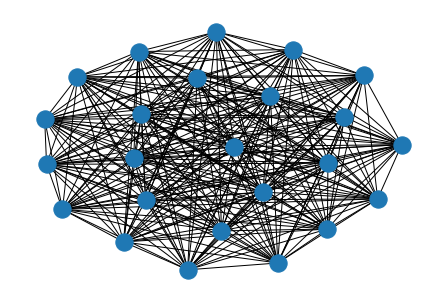

In [11]:
#Create csvs, plot graph and show summary stats
trial_run.summary_stats_all()
trial_run.plot(city)

#load node file
        brum_nodes = pd.read_csv(node_file_path, sep = ' ')
for_drop = []
for i in list(range(1,14)):
    name = 'Unnamed: ' + str(i)
    for_drop.append(name)
for_drop.remove('Unnamed: 7')
brum_nodes = brum_nodes.drop(for_drop, axis = 1)

#load trips file
#load node file - note this is a bit fiddly, could be a better way to import but chose something quick and dirty
brum_nodes = pd.read_csv(node_file_path, sep = ' ')
for_drop = []
for i in list(range(1,14)):
    name = 'Unnamed: ' + str(i)
    for_drop.append(name)
for_drop.remove('Unnamed: 7')
brum_nodes = brum_nodes.drop(for_drop, axis = 1)

# Observe example network data

In [ ]:
#after the input files are passed in the frank_wolfe class, we can observe the network
trial_run.network(city)

# Compute equilibrium flow for example city using Frank-Wolfe algorithm

In [ ]:
#compute the flow for one example city
trial_run.compute_all_link_flow(city)

In [ ]:
#this is the output of the 
print('Results for:', city)
trial_run.cities_dict[city]['all_links']['all_links'].showODFlow() #equilibrium flows
trial_run.cities_dict[city]['all_links']['all_links'].showODFlowMap() #flow map

# Compute equilibrium flow (all links in tact) for all cities using Frank-Wolfe algorithm

In [ ]:
#compute the equilibrium flow for all cities with all links in tact
for city in cities_dict.keys():
    trial_run.compute_all_link_flow(city)

In [ ]:
#select second city to check outputs are have worked okay
city = cities[1]
cities_dict[city]['csv']
trial_run.plot(city)

In [ ]:
print('Results for:', city)
trial_run.cities_dict[city]['all_links']['all_links'].showODFlow()
trial_run.cities_dict[city]['all_links']['all_links'].showODFlowMap()

In [ ]:
trial_run.compute_all_link_flow(city)['all_links']['all_links'].graph.edges

# Systematically close each link and compute equilibrium flow for example city